In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import sdeint

#Model parameters
r = 1 #growth rate of the resource
K = 10 #carrying capacity
Vmax = 1 #biomass at which the grazing rate is half maximum
V0 = 6.6 #initial population V
c0 = 2.3 #initial grazing rate

#MSE settings
nts = 2 #number of timscales
m = 2
mses = 'r=set'

#Run settings
run_nr = 'run_lq'
L = 1000 #length of datapoints considered
runs = 50
runtime = 330
resolution = 3301
distortion = np.diag([0.1, 0])
t = np.linspace(0, runtime, resolution)
y0 = np.array([V0, c0])

#Creating arrays for data
ts = np.zeros(shape=(runs, resolution))
std = np.zeros(shape=(runs,resolution-L+1))
ac = np.zeros(shape=(runs,resolution-L+1))
mse = np.zeros(shape=(runs,resolution-L+1))
se = np.zeros(shape=(runs, resolution-L+1, nts))

#ODEint for expected value and c
def model(y, t, r, K, Vmax):
    V, c = y
    dydt = [r*V*(1-V/K)- (c*V**2)/(V**2+Vmax**2), 0.001]
    return dydt

sol_ode = odeint(model, y0, t, args=(r, K, Vmax))
c = sol_ode[:,1]
#SDEint
def f(y, t):
    V, c = y
    dydt = np.array([r*V*(1-V/K)- (c*V**2)/(V**2+Vmax**2), 0.001])
    return dydt
def g(y, t):
    return distortion

#Defining multiscale entropy
def sampen(x, m, r):
    N = len(x)
    B = 0.0
    A = 0.0
    
    # Split time series and save all templates of length m
    xmi = np.array([x[i : i + m] for i in range(N - m)])
    xmj = np.array([x[i : i + m] for i in range(N - m + 1)])

    # Save all mat ches minus the self-match, compute B
    B = np.sum([np.sum(np.abs(xmii - xmj).max(axis=1) <= r) - 1 for xmii in xmi])
    
    # Similar for computing A
    m += 1
    xm = np.array([x[i : i + m] for i in range(N - m + 1)])

    A = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) <= r) - 1 for xmi in xm])

    # Return SampEn
    return -np.log(A / B)

#Creating timescales for MSE
timescales = np.empty(nts)
for i in range(nts):
    timescales[i] = i + 1

#Running the simulations
i = 0
while i < runs:
    sol_sde = sdeint.itoEuler(f, g, y0, t)
    ts[i,:] = sol_sde[:,0]
    if ts[i, resolution-1] < 4:
        continue
    i = i + 1

#Computing standard deviation
for i in range(runs):
    for j in range(resolution-L+1):
        std[i,j] = np.std(ts[i,j:j+L])

#Computing autocorrelation
for i in range(runs):
    for j in range(resolution-L+1):
        pearson = np.corrcoef(ts[i,j:j+L-1], ts[i,j+1:j+L])
        ac[i,j] = pearson[0,1]

#Computing SampEn and MSE
for i in range(runs):
    #Coarse graining timeseries
    for j in range(resolution-L+1):
        cts = np.zeros(shape=(nts, L), dtype=float)
        se_cts = np.empty(nts)
        for k in range(nts):
            for l in range(math.floor(L/(k+1))):
                cts[k,l] = np.sum(ts[i,j+l*(k+1):j+l*(k+1)+k+1])/(k+1)
            se_cts[k] = sampen(cts[k,:math.floor(L/(k+1))], 2, 0.2*np.std(ts))
        se[i,j,:] = se_cts[:]
        mse[i,j] = np.trapz(se_cts, timescales)

#Saving data
np.save(run_nr+'_ts', ts)
np.save(run_nr+'_std', std)
np.save(run_nr+'_ac', ac)
#np.save(run_nr+'_mse'+mses, mse)
#np.save(run_nr+'_se'+mses, se)

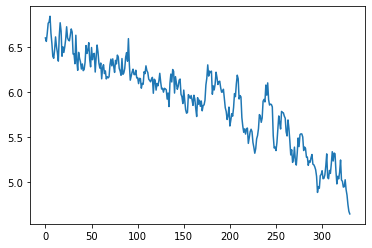

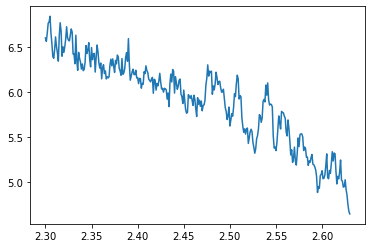

In [8]:
plt.plot(t, ts[0,:])
plt.show()
plt.plot(c, ts[0,:])
plt.show()

In [7]:
#Statistics on trends using kendall's tau
from scipy import stats
print('results trend standard deviation')
print()
print(stats.kendalltau(mean_std, c[L-1:]))
print()
print('results trend autocorrelation')
print()
print(stats.kendalltau(mean_ac, c[L-1:]))
print()
print('results trend sample entropy')
print()
print(stats.kendalltau(mean_se, c[L-1:]))
print()
print('results trend multiscale entropy')
print()
print(stats.kendalltau(mean_mse, c[L-1:]))

results trend standard deviation

KendalltauResult(correlation=0.8825197790715031, pvalue=4.31419127282722e-89)

results trend autocorrelation

KendalltauResult(correlation=0.8596059113300492, pvalue=1.2693059900587308e-84)

results trend sample entropy

KendalltauResult(correlation=-0.045454545454545456, pvalue=0.30266498031242506)

results trend multiscale entropy

KendalltauResult(correlation=0.2460815047021943, pvalue=2.402594523033363e-08)


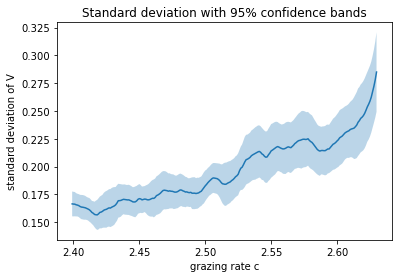

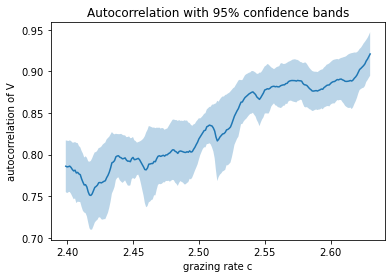

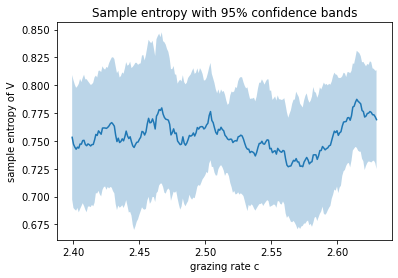

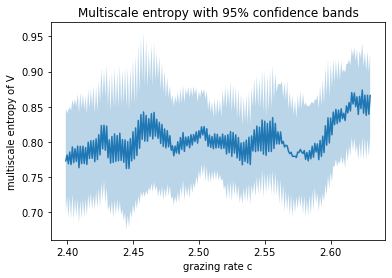

In [6]:
#Plots with confidence intervals
mean_std = np.zeros(resolution-L+1)
std_std = np.zeros(resolution-L+1)
upper_std = np.zeros(resolution-L+1)
lower_std = np.zeros(resolution-L+1)

for i in range(resolution-L+1):
    mean_std[i] = np.mean(std[:,i])
    std_std[i] = np.std(std[:,i])
    upper_std[i] = mean_std[i] + (1.96 * std_std[i])/np.sqrt(runs)
    lower_std[i] = mean_std[i] - (1.96 * std_std[i])/np.sqrt(runs)

plt.plot(c[L-1:], mean_std)
plt.fill_between(c[L-1:], lower_std, upper_std, alpha=0.3)
plt.title('Standard deviation with 95% confidence bands')
plt.xlabel('grazing rate c')
plt.ylabel('standard deviation of V')
#plt.text(2.4, 0.304, """Kendalls tau = 0.99
#(p-value = 0.0)""", bbox=dict(facecolor='white', alpha=0.5))
plt.savefig(run_nr+'_plot_std', dpi=300)
plt.show()

mean_ac = np.zeros(resolution-L+1)
std_ac = np.zeros(resolution-L+1)
upper_ac = np.zeros(resolution-L+1)
lower_ac = np.zeros(resolution-L+1)

for i in range(resolution-L+1):
    mean_ac[i] = np.mean(ac[:,i])
    std_ac[i] = np.std(ac[:,i])
    upper_ac[i] = mean_ac[i] + (1.96 * std_ac[i])/np.sqrt(runs)
    lower_ac[i] = mean_ac[i] - (1.96 * std_ac[i])/np.sqrt(runs)

plt.plot(c[L-1:], mean_ac)
plt.fill_between(c[L-1:], lower_ac, upper_ac, alpha=0.3)
plt.title('Autocorrelation with 95% confidence bands')
plt.ylabel('autocorrelation of V')
plt.xlabel('grazing rate c')
#plt.text(2.4, 0.99918, """Kendalls tau = 0.98
#(p-value = 0.0)""", bbox=dict(facecolor='white', alpha=0.5))
plt.savefig(run_nr+'_plot_ac', dpi=300)
plt.show()

mean_se = np.zeros(resolution-L+1)
std_se = np.zeros(resolution-L+1)
upper_se = np.zeros(resolution-L+1)
lower_se = np.zeros(resolution-L+1)

for i in range(resolution-L+1):
    mean_se[i] = np.mean(se[:,i,0])
    std_se[i] = np.std(se[:,i,0])
    upper_se[i] = mean_se[i] + (1.96 * std_se[i])/np.sqrt(runs)
    lower_se[i] = mean_se[i] - (1.96 * std_se[i])/np.sqrt(runs)

plt.plot(c[L-1:], mean_se)
plt.fill_between(c[L-1:], lower_se, upper_se, alpha=0.3)
plt.title('Sample entropy with 95% confidence bands')
plt.ylabel('sample entropy of V')
plt.xlabel('grazing rate c')
#plt.text(2.4, 0.64, """Kendalls tau = 0.98
#(p-value = 0.0)""", bbox=dict(facecolor='white', alpha=0.5))
plt.savefig(run_nr+'_plot_se'+mses, dpi=300)
plt.show()

mean_mse = np.zeros(resolution-L+1)
std_mse = np.zeros(resolution-L+1)
upper_mse = np.zeros(resolution-L+1)
lower_mse = np.zeros(resolution-L+1)

for i in range(resolution-L+1):
    mean_mse[i] = np.mean(mse[:,i])
    std_mse[i] = np.std(mse[:,i])
    upper_mse[i] = mean_mse[i] + (1.96 * std_mse[i])/np.sqrt(runs)
    lower_mse[i] = mean_mse[i] - (1.96 * std_mse[i])/np.sqrt(runs)

plt.plot(c[L-1:], mean_mse)
plt.fill_between(c[L-1:], lower_mse, upper_mse, alpha=0.3)
plt.title('Multiscale entropy with 95% confidence bands')
plt.ylabel('multiscale entropy of V')
plt.xlabel('grazing rate c')
#plt.text(2.4, 1.75, """Kendalls tau = 0.98
#(p-value = 0.0)""", bbox=dict(facecolor='white', alpha=0.5))
plt.savefig(run_nr+'_plot_mse'+mses, dpi=300)
plt.show()

In [12]:
runs_time = np.linespace(0,runs)

0.5031196932894016

In [14]:
np.std(ts[1,:])

0.505911571350199

In [ ]:
print(mse)